In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from saxs_data_processing import io, manipulate, target_comparison, subtract

## Load scattering data

In [4]:
background_fps = ['/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_05_StoberRandomCampaignV2/03210_B9-T1_Ethanol_background__000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_07_randomcampaignV3/data/03218_D1-T1_Ethanol_background_1_000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_11_randomV3_round2/03289_H6-T2_EtOH_background_1_000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_15_Highlights_replicates/03357_D5-T2_Background_1_EtOH_000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_17_randomBaselineV4/data/03439_C1-T2_EtOH_1_000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_11_05_optimizationRound1/03533_F9-T1_Ethanol_background_1_000.dat']

In [9]:
sample_data, uuid2bkg = io.load_biocube_data_with_background(background_fps, 24)

/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/io.py:150: UserWarning: Duplicate UUID found for b8953350-d5ad-4c99-b929-ebfe8febd0df. Check your file naming
  warnings.warn(
/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/io.py:150: UserWarning: Duplicate UUID found for ea0d2ca6-8818-45f8-b5e3-04858133284a. Check your file naming
  warnings.warn(
/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/io.py:150: UserWarning: Duplicate UUID found for 0ec4dd81-7487-4689-96b9-b0f646a2047d. Check your file naming
  warnings.warn(


## Set parameters for processing

In [3]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1024 # number of grid points to interpolate q on.

In [5]:
target_r_nm = 60
target_r_angs = target_r_nm*10
target_pdi = 0.08
sld_silica = 8.575
sld_etoh = 9.611

In [6]:
# SavGol denoise filter parameters
savgol_n = 15
savgol_order = 3
# minimum data length - data with less than ~100 data points is due to valid data selection step in subtraction and is likley too noisy to do anything with.
min_data_len = 100

# spline fit parameters
s = 0.05
k = 3

#scale parameters
n_avg = 100


## Calculate target scattering

In [10]:
q_grid = np.linspace(np.log10(q_min_spl), np.log10(q_max_spl), n_interpolate_gridpts)

q_grid_nonlog = 10**q_grid
target_I = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, target_pdi, sld_silica, sld_etoh)
target_I = np.log10(target_I)

## Run processing for 'best' scattering example

In [11]:
best_uuid = 'a6ee3a08-02cd-4703-9d6c-3721dad590c8'

In [12]:
data_val = sample_data[best_uuid]

In [15]:
# Load best example
uuid_val = best_uuid
# pre-process example
meas_entry = {}
meas_entry['original_data'] = data_val[0]
background = uuid2bkg[uuid_val]
meas_entry['background'] = background[0]
# 1. Subtract background and select q range
subtracted = subtract.chop_subtract(data_val[0], background[0], hiq_thresh=1)

    

subtracted = subtracted[subtracted['q'] < q_max_subtract]
subtracted = subtracted[~subtracted['I'].isna()]
subtracted = subtracted[subtracted['I'] > 0] # drop negative values 
# screen on dataset length
meas_entry['subtracted_clipped'] = subtracted
meas_entry['status'] = 'valid'


# 2. Convert everything into log10 space
q_log = np.log10(subtracted['q'].to_numpy())
I_log = np.log10(subtracted['I'].to_numpy())

meas_entry['q_log'] = q_log
meas_entry['I_log'] = I_log

# 3. denoise filter on intensity

I_savgol = manipulate.denoise_intensity(I_log, savgol_n = savgol_n, savgol_order = savgol_order)

meas_entry['I_savgol'] = I_savgol

# 4. Spline fit and interpolate
I_spline = manipulate.fit_interpolate_spline(q_log, I_savgol, q_grid, s = s, k = k)

meas_entry['I_spline'] = I_spline

# 5. scale onto target
I_scaled = manipulate.scale_intensity_highqavg(I_spline, target_I, n_avg = n_avg)

meas_entry['I_scaled'] = I_scaled

## Plot target and processed measurement

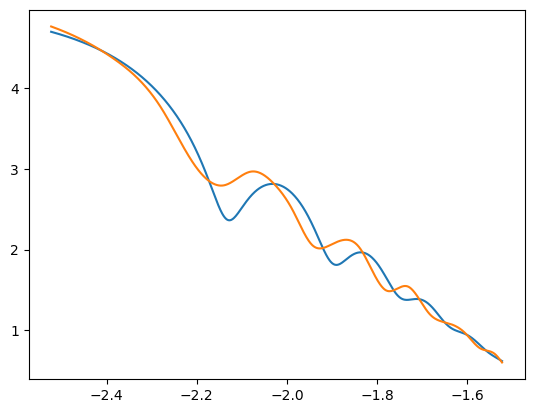

In [16]:
fig, ax = plt.subplots()
ax.plot(q_grid, target_I)
ax.plot(q_grid, I_scaled)
plt.show()

### Using PyTorch version

In [19]:
t = (q_grid - min(q_grid))/(max(q_grid) - min(q_grid))

In [20]:
from apdist.torch import AmplitudePhaseDistance as torch_apdist 
import torch 
optim_kwargs = {"n_iters":50, 
                "n_basis":15, 
                "n_layers":15,
                "domain_type":"linear",
                "basis_type":"palais",
                "n_restarts":50,
                "lr":1e-1,
                "n_domain":n_interpolate_gridpts
                }
amplitude, phase, output = torch_apdist(torch.from_numpy(t), # all the inputs should be torch.Tensor
                                        torch.from_numpy(target_I), 
                                        torch.from_numpy(I_scaled), 
                                        **optim_kwargs
                                        )
print("Amplitude : %2.4f, Phase : %2.4f"%(amplitude, phase))

tensor(0.9176)
tensor(1.3188, dtype=torch.float64)
Amplitude : 1.1484, Phase : 0.4089


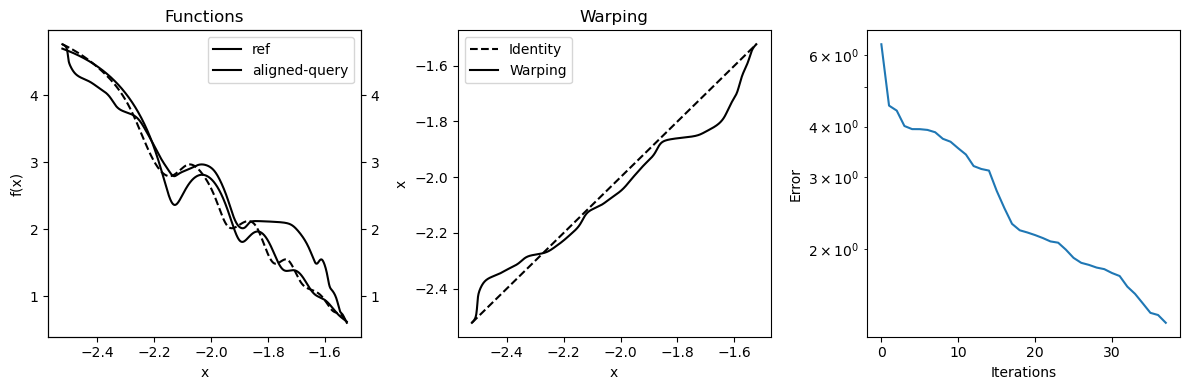

In [22]:
from apdist.torch import plot_warping as plot_warping_torch

plot_warping_torch(q_grid, target_I, I_scaled, output)

### Using Numpy version

In [24]:
from apdist.distances import AmplitudePhaseDistance as dist

optim_kwargs = {"optim":"DP", "grid_dim":10}
dist(t, target_I, I_scaled, **optim_kwargs)

(0.34283261234188767, 0.16181550480781765)

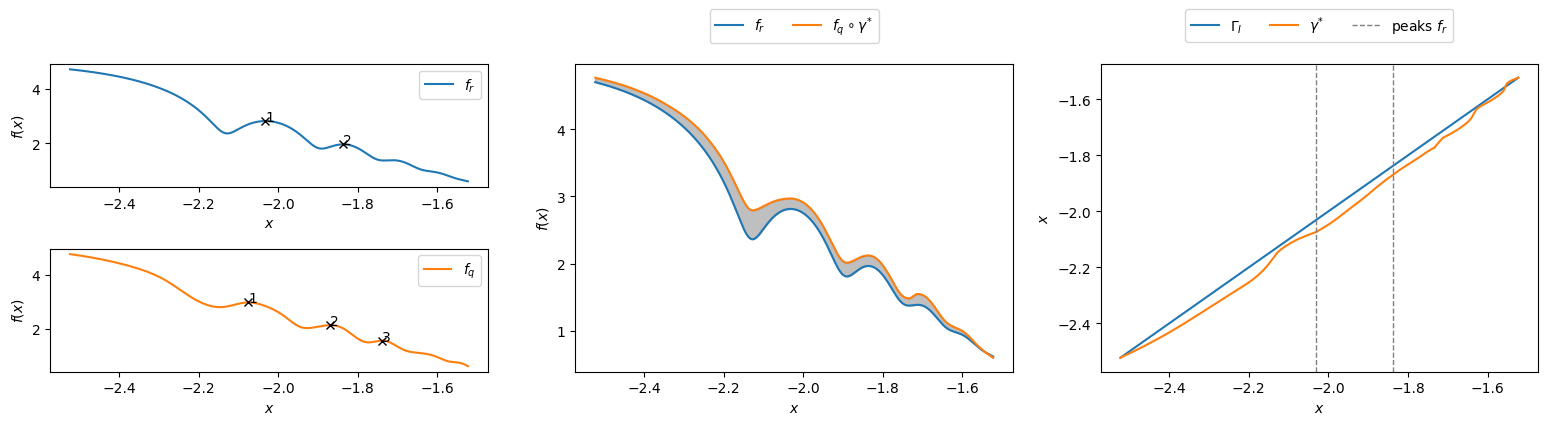

In [26]:
# Plot warped functions and gamma 
from apdist.utils import plot_warping 
from apdist.geometry import SquareRootSlopeFramework as SRSF

# for SRSF representation, we map the domain into [0,1]
srsf = SRSF(t)
q_ref = srsf.to_srsf(target_I)
q_query = srsf.to_srsf(I_scaled)
gamma = srsf.get_gamma(q_ref, q_query, **optim_kwargs)
f_query_gamma = srsf.warp_f_gamma(I_scaled, gamma)
plot_warping(q_grid, target_I, I_scaled, f_query_gamma, gamma)
plt.show()